In [ ]:
# In [1]: Full pipeline with Excel‐exported histograms + plotting

import os
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import tifffile
from scipy.ndimage import gaussian_filter

In [ ]:
# --- USER: list your folders here ---
from pathlib import Path
BASE_DIR = Path.cwd()
if BASE_DIR.name == "notebooks":
    BASE_DIR = BASE_DIR.parent

nii_dirs = [
    BASE_DIR / "data" / "raw",
]
mask_path = BASE_DIR / "data" / "masks" / "zbb_full.tif"

# --- helper to load & binarize mask ---
def load_mask(mask_path, sample_shape):
    mask = tifffile.imread(mask_path)
    if mask.shape != sample_shape:
        mask_t = mask.transpose((2,1,0))
        if mask_t.shape == sample_shape:
            mask = mask_t
        else:
            raise ValueError(f"Mask {mask.shape} ≠ volume {sample_shape}")
    u = np.unique(mask)
    return (mask > np.mean(u)) if not set(u).issubset({0,1}) else mask.astype(bool)


In [ ]:
# --- collect all files & prepare outputs ---
batch = []
for d in nii_dirs:
    if not d.exists(): raise FileNotFoundError(d)
    od = d / "prep_permutation"
    od.mkdir(exist_ok=True)
    fs = sorted(d.glob("*_02_*.nii.gz")) #change file name
    if not fs: raise RuntimeError(f"No matches in {d}")
    for f in fs:
        batch.append({'nii':f, 'out_dir':od})

# --- load mask once against first shape ---
first_shape = nib.load(str(batch[0]['nii'])).shape
mask = load_mask(mask_path, first_shape)


# --- Stage 1: mask, blur, max, → DataFrames ---
hist_dfs, stats = {}, []   # stats will collect (stem, gmin, gmax)

for entry in batch:
    f    = entry['nii']
    stem = f.stem
    # load & axial-stack
    data = np.transpose(nib.load(str(f)).get_fdata(), (2,1,0))
    m    = np.transpose(mask,                                  (2,1,0))
    db   = gaussian_filter(data * m, sigma=2)

    # compute min & max
    gmin = db.min()
    gmax = db.max()
    stats.append((stem, gmin, gmax))
    print(f"{stem} → min {gmin:.2f}, max {gmax:.2f}")

    # 90-bin histogram
    counts, edges = np.histogram(db.ravel(), bins=90) #suitbale for 32-bit images
    ch = stem.split('_')[1]
    hist_dfs[stem] = pd.DataFrame({
        f"bins_{ch}":     edges[:-1],
        f"channel_{ch}":  counts
    })

# build the stats DataFrame
stats_df = pd.DataFrame(stats, columns=["file", "min", "max"])


Mut_exp_10_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.02, max 13882.79
Mut_exp_11_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.06, max 11035.75
Mut_exp_12_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.02, max 10805.00
Mut_exp_13_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.00, max 16829.79
Mut_exp_14_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.04, max 10911.03
Mut_exp_1_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.01, max 10597.79
Mut_exp_3_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.10, max 10089.07
Mut_exp_6_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.02, max 13039.76
Mut_exp_7_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.00, max 11859.29
Mut_exp_8_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.03, max 11613.66
Mut_exp_9_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.02, max 15751.91
Mut_unexp_10_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.00, max 5297.17
Mut_unexp_11_HCR10_fabp7a_270324_02_reg_Warped.nii → min -0.00, max 3522.38
Mut_unexp_4_HCR10_fabp7a_2703

In [ ]:
excel_path = BASE_DIR / "outputs" / "maskedfiltered_histogram_and_stats.xlsx"
excel_path.parent.mkdir(parents=True, exist_ok=True)

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    # 1) stats sheet
    stats_df.to_excel(writer, sheet_name="stats", index=False)
    # 2) per-file histograms
    for sheet, df in hist_dfs.items():
        # sheet names ≤31 chars
        df.to_excel(writer, sheet_name=sheet[:31], index=False)

print(f"→ Data (histograms + stats) written to {excel_path}")


In [ ]:
def plot_histograms_from_excel(excel_path, save_fig=False):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from pathlib import Path

    # 1) load & drop stats
    xls = pd.read_excel(excel_path, sheet_name=None)
    xls.pop('stats', None)
    histograms = xls

    # 2) split sheets
    only_unexp = [s for s in histograms if '_unexp_' in s.lower() ]
    only_exp   = [s for s in histograms if '_exp_'   in s.lower() ]

    # 3) prepare colors
    cu = plt.cm.Oranges(np.linspace(0.1,0.9, max(len(only_unexp),1)))
    cb = plt.cm.Blues  (np.linspace(0.1,0.9, max(len(only_exp),  1)))

    # 4) one big overlaid figure
    plt.figure(figsize=(20,10))
    for i, s in enumerate(only_unexp + only_exp):
        df = histograms[s]
        # grab whichever columns start with bins_ and channel_
        bins_col = next(c for c in df.columns if c.startswith('bins_'))
        ch_col   = next(c for c in df.columns if c.startswith('channel_'))

        # label = chars 25–37 of the sheet name
        label = s[:31]

        # pick color
        if s in only_unexp:
            color = cu[only_unexp.index(s)]
        else:
            color = cb[only_exp.index(s)]

        plt.plot(df[bins_col], df[ch_col], label=label, color=color)

    plt.yscale('log')
    plt.xlabel('Intensity')
    plt.ylabel('Count (log scale)')
    plt.title('Overlaid Histograms')
    plt.legend(fontsize='large', ncol=2)
    plt.tight_layout()

    if save_fig:
        out_dir = Path(excel_path).parent
        plt.savefig(out_dir / "overlaid_histograms.png")

    plt.show()



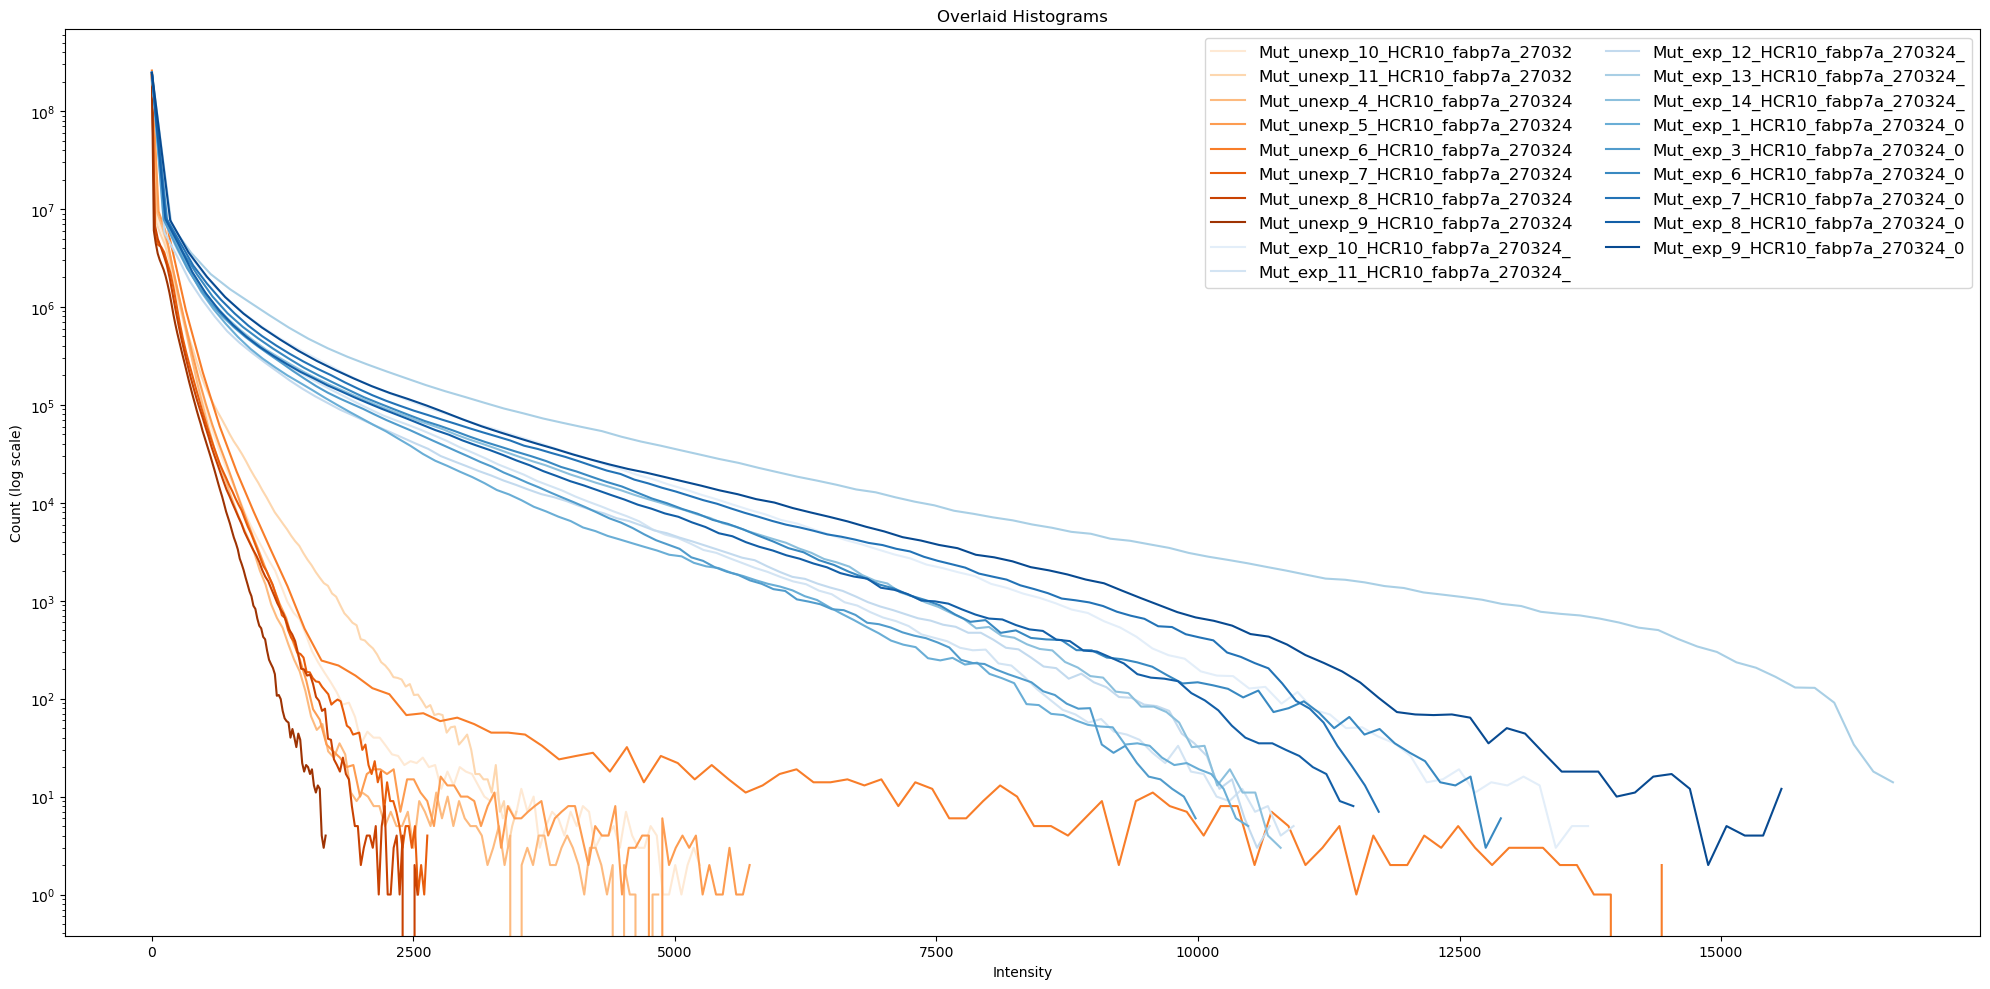

In [ ]:
# --- Stage 1b: plot directly from that Excel sheet ---
plot_histograms_from_excel(excel_path, save_fig=True) #change to false if you don't want the figure to be saved

In [ ]:
# --- Stage 2: get rescale bounds ---
lower = float(input("Enter lower intensity bound (→0): "))
upper = float(input("Enter upper intensity bound (→255): "))

# --- Stage 3: rescale & save TIFFs in dorsal (axial) order ---
for entry in batch:
    f   = entry['nii']; od = entry['out_dir']
    print(f"Rescaling {f.stem}…")
    data = np.transpose(nib.load(str(f)).get_fdata(), (2,1,0))
    m    = np.transpose(mask,                                  (2,1,0))
    db   = gaussian_filter(data * m, sigma=2)
    r    = np.clip((db - lower)/(upper - lower), 0, 1)
    u8   = (r * 255).astype(np.uint8)
    outp = od / f"{f.stem}_rescaled8bit.tiff"
    tifffile.imwrite(outp, u8, imagej=False)
    print(f"  saved → {outp.name} (shape {u8.shape})")

Enter lower intensity bound (→0):  0
Enter upper intensity bound (→255):  16830


Rescaling Mut_exp_10_HCR10_fabp7a_270324_02_reg_Warped.nii…
  saved → Mut_exp_10_HCR10_fabp7a_270324_02_reg_Warped.nii_rescaled8bit.tiff (shape (420, 616, 1030))
Rescaling Mut_exp_11_HCR10_fabp7a_270324_02_reg_Warped.nii…
  saved → Mut_exp_11_HCR10_fabp7a_270324_02_reg_Warped.nii_rescaled8bit.tiff (shape (420, 616, 1030))
Rescaling Mut_exp_12_HCR10_fabp7a_270324_02_reg_Warped.nii…
  saved → Mut_exp_12_HCR10_fabp7a_270324_02_reg_Warped.nii_rescaled8bit.tiff (shape (420, 616, 1030))
Rescaling Mut_exp_13_HCR10_fabp7a_270324_02_reg_Warped.nii…
  saved → Mut_exp_13_HCR10_fabp7a_270324_02_reg_Warped.nii_rescaled8bit.tiff (shape (420, 616, 1030))
Rescaling Mut_exp_14_HCR10_fabp7a_270324_02_reg_Warped.nii…
  saved → Mut_exp_14_HCR10_fabp7a_270324_02_reg_Warped.nii_rescaled8bit.tiff (shape (420, 616, 1030))
Rescaling Mut_exp_1_HCR10_fabp7a_270324_02_reg_Warped.nii…
  saved → Mut_exp_1_HCR10_fabp7a_270324_02_reg_Warped.nii_rescaled8bit.tiff (shape (420, 616, 1030))
Rescaling Mut_exp_3_HCR10_fabp

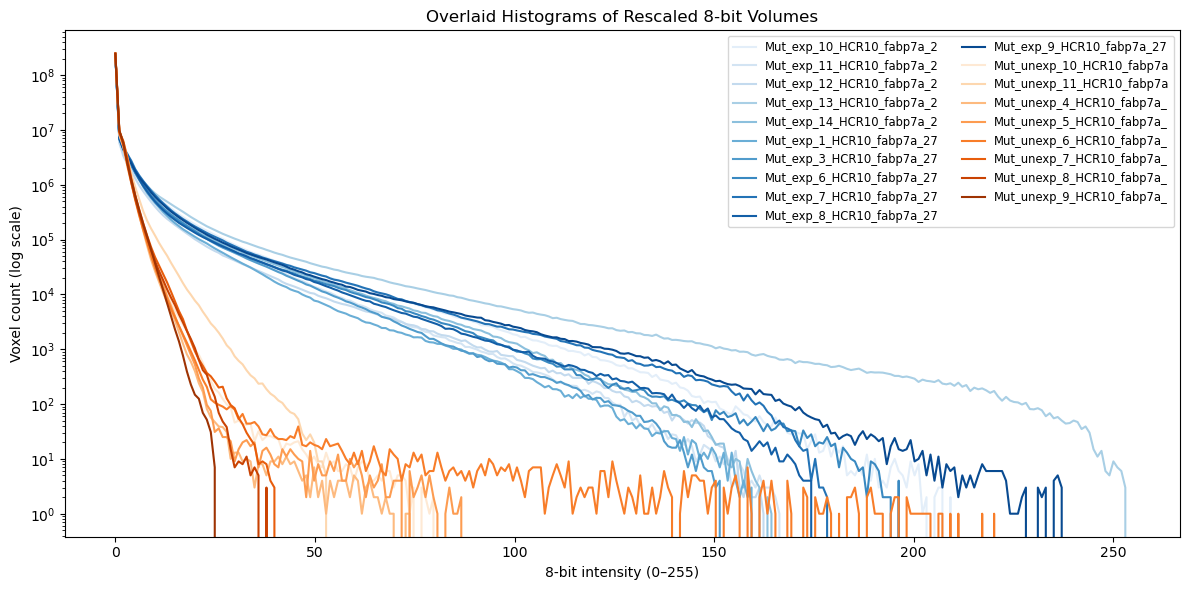

In [ ]:
# --- Stage 4: overlaid 8-bit TIFF histograms (log‐scale y, 25–37 legend slice) ---

# === USER: list the folders holding your rescaled 8-bit tiffs here ===
rescaled_dirs = [
    d / "prep_permutation" for d in nii_dirs if (d / "prep_permutation").exists()
]
# count files for coloring
all_files = []
for d in rescaled_dirs:
    all_files += sorted(d.glob("*2_reg*")) #change based on the naming
n_unexp = sum('unexp'   in p.stem.lower() for p in all_files)
n_exp   = sum('exp'     in p.stem.lower() and 'unexp' not in p.stem.lower()
              for p in all_files)

cols_unexp = plt.cm.Oranges(np.linspace(0.1, 0.9, max(n_unexp,1)))
cols_exp   = plt.cm.Blues  (np.linspace(0.1, 0.9, max(n_exp,  1)))

plt.figure(figsize=(12, 6))
i_un, i_ex = 0, 0

for res_dir in rescaled_dirs:
    if not res_dir.exists():
        print(f"[!] {res_dir} not found, skipping.")
        continue

    for tiff_p in sorted(res_dir.glob("*2_reg*")):
        vol8 = tifffile.imread(str(tiff_p))  # (Z,Y,X), uint8
        counts, edges = np.histogram(vol8.ravel(),
                                     bins=256,
                                     range=(0, 255))

        stem = tiff_p.stem
        # 25th–37th characters (1-indexed) → indices [24:37]
        label = stem[0:25]

        # pick color
        if 'unexp' in stem.lower():
            color = cols_unexp[i_un]
            i_un += 1
        elif 'exp' in stem.lower():
            color = cols_exp[i_ex]
            i_ex += 1
        else:
            color = None

        plt.plot(edges[:-1], counts, label=label, color=color)

plt.yscale('log')
plt.xlabel('8-bit intensity (0–255)')
plt.ylabel('Voxel count (log scale)')
plt.title('Overlaid Histograms of Rescaled 8-bit Volumes')
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()
